In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns
import scipy.io as sp_io
from scipy.stats import spearmanr as sp_spearmanr

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import TheilSenRegressor
import umap
import networkx as nx
from statsmodels.stats.multitest import fdrcorrection
import pickle

from brainsmash.mapgen.stats import spearmanr as bs_spearmanr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# tSNE

In [2]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale, pca_obj, tsne_obj, umap_obj =  pickle.load( open('../res/0.preprocessing_DR.pkl', 'rb') )

In [3]:
tsne_dat = pd.DataFrame(tsne_obj.embedding_, columns=['tSNE1', 'tSNE2'])
tsne_dat["Sample"] = expr.columns
tsne_dat["Group"] = "INS " + tsne_dat['Sample'].str.split("-", expand=True)[0]

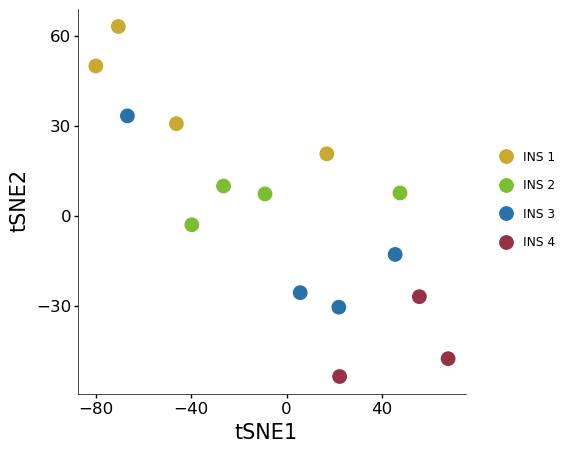

<ggplot: (8768890027228)>

In [7]:
tsne_plot = ( p9.ggplot(p9.aes(x="tSNE1", y="tSNE2", color="Group"), data=tsne_dat)
             + p9.geom_point(size=5)
             #+ p9.geom_text(p9.aes(x="tSNE1", y="tSNE2", label="Sample"), color="black", size=8)
             #+ p9.coord_equal(ratio=1.3)
             + p9.scale_color_manual(values=["#C9A92E", "#7BBE31", "#2972A9", "#973144"])
             + p9.theme_classic()
             + p9.theme(axis_title=p9.element_text(color="black", size=15),
                        axis_text=p9.element_text(color="black", size=12),
                        legend_title=p9.element_blank(),
                        axis_line=p9.element_line(size=0.5),
                        figure_size=(5, 5) )
)
p9.ggsave(tsne_plot, "../res/use_v1/tSNE.tiff", units="in", dpi=300, verbose=False)
tsne_plot

# metrics

In [8]:
def calc_strength_fraction(adj):
    W = adj[:4, :4].sum()+adj[4:8, 4:8].sum()+adj[8:12, 8:12].sum()+adj[12:, 12:].sum()
    return W/(adj.sum()-W)

def calc_conductance(nx_adj):
    cond = 0
    for set_S in [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]:
        cond += nx.algorithms.conductance(nx_adj, set_S, weight="weight")
    return -cond

def calc_normalized_cut(nx_adj):
    ncut = 0
    for set_S in [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14]]:
        ncut += nx.algorithms.normalized_cut_size(nx_adj, set_S, weight="weight")
    return -ncut

def significant_test_for_index(corr_mtx, n_perm=1000):
    # 0. data preparation
    corr_array = np.array(corr_mtx)
    np.fill_diagonal(corr_array, 0)
    corr_array_nx = nx.from_numpy_array(corr_array).to_undirected()

    # 1. calc index
    seg_index = np.array([calc_strength_fraction(corr_array), calc_conductance(corr_array_nx), calc_normalized_cut(corr_array_nx)])

    # 2. permutation
    perm_index = np.empty(shape=(n_perm, 3))
    for k in range(n_perm):
        tmp_idx = np.random.permutation(corr_array.shape[0])
        perm_corr = corr_array[tmp_idx, :][:, tmp_idx]
        perm_corr_g = nx.from_numpy_array(perm_corr).to_undirected()

        perm_index[k, 0] = calc_strength_fraction(perm_corr)
        perm_index[k, 1] = calc_conductance(perm_corr_g)
        perm_index[k, 2] = calc_normalized_cut(perm_corr_g)

    pval = ((perm_index>seg_index).sum(axis=0)+1)/n_perm

    # 3. multiple test correction
    _, fdr_bh = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)

    # 4. results
    seg_index[1:] = -seg_index[1:]
    perm_index[:, 1:] = -perm_index[:, 1:]

    return seg_index, perm_index, pval, fdr_bh

In [9]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale, pca_obj, tsne_obj, umap_obj =  pickle.load( open('../res/0.preprocessing_DR.pkl', 'rb') )

In [10]:
corr_pr = np.corrcoef(expr_scale)
corr_pr[corr_pr<0] = 0

In [42]:
pr_res = significant_test_for_index(corr_pr, n_perm=1000)
pr_res[-2], pr_res[-1]


(array([0.005, 0.001, 0.002]), array([0.005, 0.003, 0.003]))

In [45]:
#pickle.dump(pr_res, open('../res/use_v1/pr_res.pkl', 'wb'))
pr_res = pickle.load(open("../res/use_v1/pr_res.pkl", 'rb'))

In [59]:
pr_dat_boxplot = pd.DataFrame(pr_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
pr_dat_boxplot['Index'] = pd.Categorical(pr_dat_boxplot["Index"], categories=["Strength fraction", "Conductance", "Normalized cut"])
pr_dat_scatter = pd.DataFrame([pr_res[0], pr_res[-1]], index=["Value", "FDR"]).T
pr_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
pr_dat_scatter["y"] = pr_dat_boxplot.groupby(pr_dat_boxplot["Index"]).quantile(0.99).loc[pr_dat_scatter["Index"]].values + 0.01
pr_dat_scatter.loc[0, "y"] = 0.72
pr_dat_scatter['FDR'] = "FDR="+pr_dat_scatter['FDR'].astype(str)
pr_dat_scatter["Index"] = pd.Categorical(pr_dat_scatter["Index"], categories=["Strength fraction", "Conductance", "Normalized cut"])
pr_dat_scatter

,Value,FDR,Index,y
0,0.674678,FDR=0.005,Strength fraction,0.720000
1,2.340785,FDR=0.003,Conductance,3.748510
2,3.150859,FDR=0.003,Normalized cut,5.004176


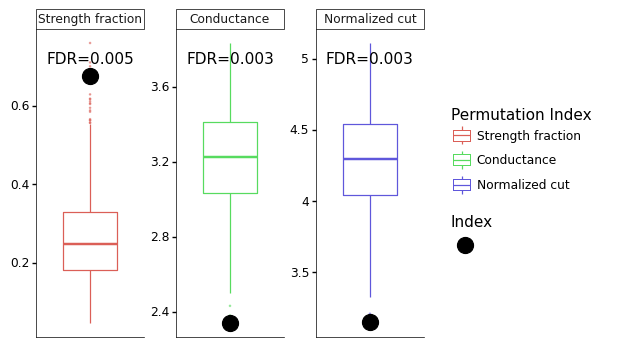

<ggplot: (8768888859278)>

In [108]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="o", outlier_alpha=0.5, outlier_size=0.05)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black"),
             axis_line=p9.element_line(size=0.5),
             strip_background=p9.element_rect(size=0.5),
             figure_size=(5, 4)
             
            )
)
p9.ggsave(pr_plot, "../res/use_v1/pr_plot.tiff", units="in", dpi=300, verbose=False )
pr_plot

# Heatmap

In [62]:
expr = pd.read_table("../data/2.prodata/protomics_expr_processed.tsv", index_col=0)
expr.columns = "INS " + expr.columns
diff_pro_list = pd.read_table("../data/2.prodata/combined_genelist.txt", header=None)[0]
diff_pro_expr = expr.loc[diff_pro_list, ]
diff_pro_expr

,INS 1-2,INS 1-4,INS 1-6,INS 1-7,INS 2-9,INS 2-10,INS 2-12,INS 2-14,INS 3-16,INS 3-19,INS 3-21,INS 3-24,INS 4-26,INS 4-29,INS 4-31
F7HA02|GALT,-0.264370,-0.323935,-0.432893,-0.387641,-0.198134,-0.255937,-0.264348,-0.307689,-0.312718,-0.288776,-0.264101,-0.256156,-0.129658,-0.019937,-0.062922
H9EME4|STX1B,0.001334,-0.042056,0.017199,-0.013446,-0.019973,-0.036019,0.015667,-0.124940,0.001319,0.040204,0.034257,-0.051289,0.173181,0.337547,0.308714
F7D5P2|SERPINH1,-0.257972,-0.239429,-0.112043,-0.271625,-0.042949,-0.102362,-0.106209,-0.176934,-0.129737,-0.135007,-0.100774,-0.174574,0.052372,0.027726,0.037295
F6R387|MAPT,0.006658,-0.099631,0.003987,0.021256,-0.269661,-0.128048,0.120819,-0.173996,0.140740,0.128268,0.264811,-0.203292,0.434243,0.767903,0.876630
A0A1D5Q3K8|MAPK8IP3,0.011962,-0.025631,0.048422,0.036994,0.077237,0.061895,0.071701,0.011661,0.014447,0.112540,0.097935,0.021062,0.219723,0.209952,0.308714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A1D5R675|ATP5ME,-0.009373,-0.013433,0.030290,-0.075551,0.060849,-0.010579,0.047771,-0.003908,-0.014593,0.063044,0.053657,0.030180,0.120188,0.049001,0.192295
F6ZGL8|PPCS,0.069054,-0.072664,-0.051482,-0.018859,-0.006627,-0.057796,-0.060317,-0.182829,-0.188691,0.020890,-0.006682,-0.033537,0.114041,0.010206,0.195965
A0A1D5R641|HSPA4L,0.091774,0.109396,0.068867,0.046096,0.063383,0.010502,0.020852,0.047348,0.040349,0.113756,0.116503,0.079955,0.075333,0.190937,0.274417
A0A1D5Q7M9|ASAP2,0.043383,0.080604,0.145467,-0.044854,-0.003973,-0.031972,0.103818,0.104125,0.088317,0.148580,0.143310,0.068620,0.236797,0.134832,0.251091


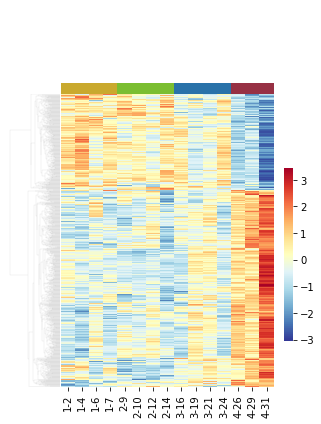

In [114]:
colormap = ["#C9A92E"]*4 + ["#7BBE31"]*4 + ["#2972A9"]*4 + ["#973144"]*3
sns.clustermap(diff_pro_expr, z_score=0, yticklabels=False, #vmin=-2, vmax=2,
               figsize=(4, 6),
               cmap="RdYlBu_r",
               row_cluster=True, col_cluster=False,
               col_colors=colormap,
               cbar_pos=(1, .2, .03, .4),
               tree_kws= {
                          'colors':'black',#线色
                          'linewidths':0.05},#线宽
                )
#plt.legend(labels=["INS 1", "INS 2", "INS 3", "INS 4"], colors=["#C9A92E", "#7BBE31", "#2972A9", "#973144"])
plt.savefig("../res/use_v1/heatmap.tiff", bbox_inches="tight", dpi=300)
plt.show()

In [116]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise

# Gredient correlation

In [3]:
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale = pd.DataFrame(preprocessing.scale(expr, axis=1), index=expr.index, columns=expr.columns)
dist = sp_io.loadmat("../data/0.rawdata/from_cl/INSsam_eud.mat")['eud']

group = "INS "+pd.Series(expr_scale.columns).str.split("-", expand=True)[0].values
diff_pro_genelist = pd.read_csv("../data/2.prodata/combined_genelist.txt", header=None)[0]
diff_pro_expr = expr_scale.loc[diff_pro_genelist, ]

gradient = pd.read_csv("../data/0.rawdata/from_cl/insula_gredient.tsv", sep="\t", index_col=0, header=None).values
sample_gradient = gradient[:15].reshape((15, ))
region_gradient = gradient[15:].reshape((4, ))
sample_gradient, region_gradient

(array([0.01408533, 0.00940217, 0.09424626, 0.62303919, 0.63558471,
        0.75779951, 0.82817811, 0.78731966, 0.88464737, 0.88901967,
        0.93349958, 0.93518335, 0.96009874, 0.96331143, 0.97923142]),
 array([0.1852, 0.7522, 0.9106, 0.9675]))

## diff pro

In [4]:
diff_pro_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(diff_pro_expr.T).flatten()
diff_pro_rho, _ = sp_spearmanr(sample_gradient, diff_pro_PC1)

n_perm = 10000
surrogate_maps = pickle.load(open("../res/3.surro_maps_structure.pkl", 'rb'))
surrogate_rho = bs_spearmanr(diff_pro_PC1, surrogate_maps)
diff_pro_pval = (1+(surrogate_rho > diff_pro_rho).sum())/(1+n_perm)
diff_pro_rho, diff_pro_pval

(0.6928571428571427, 0.0047995200479952005)

In [5]:
TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), preprocessing.minmax_scale(diff_pro_PC1))
TheilSen_obj.coef_, TheilSen_obj.intercept_

(array([0.6287611]), -0.23977714265675273)

In [6]:
diff_pro_dat = pd.DataFrame([sample_gradient, preprocessing.minmax_scale(diff_pro_PC1)], index=['x', 'y']).T
diff_pro_dat['Group'] = group

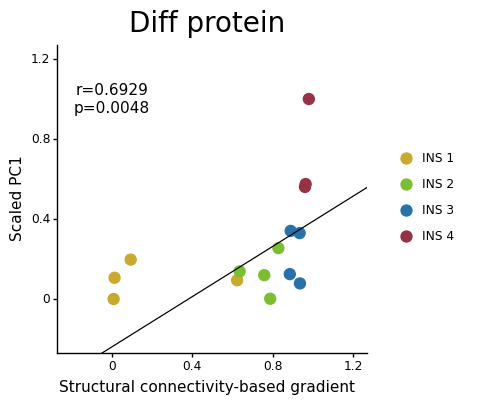

<ggplot: (8768891594376)>

In [69]:
diff_pro_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="Group"), diff_pro_dat)
  + p9.geom_point(size=4)
  + p9.geom_abline(slope=TheilSen_obj.coef_, intercept=TheilSen_obj.intercept_, color="black")
  #+ p9.geom_text(p9.aes(x=[0], y=[1], label=[f"r={rho:.4f}\np={pval:.4f}"]), color="black")
  + p9.annotate("text", x=0, y=1, label=f"r={diff_pro_rho:.4f}\np={diff_pro_pval:.4f}", color="black")
  + p9.scale_color_manual(values=["#C9A92E", "#7BBE31", "#2972A9", "#973144"])
  + p9.theme_classic()
  + p9.xlab("Structural connectivity-based gradient") + p9.ylab("Scaled PC1") + p9.ggtitle("Diff protein")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(4, 4)
             )
)
#p9.ggsave(diff_pro_plot, "../res/use_v1/diff_pro_corr.pdf", verbose=False)
diff_pro_plot

## Layer marker

In [7]:
layer_marker_filename = "../data/0.rawdata/from_papers/neuron_11047_mmc6.xlsx"
layer_marker = [pd.read_excel(layer_marker_filename, sheet_name=f"Layer{i}enriched")["Gene Symbol"].dropna().unique() for i in range(2, 7) ]

In [8]:
layer_dat_point = []
layer_dat_anno = []

layer_roman = ["II", "III", "IV", "V", "VI"]

for i, genelist in enumerate(layer_marker):
    idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(genelist)
    layer_expr = expr_scale.values[idx, :]
    #layer_expr_PC1 = np.mean(layer_expr, axis=0).flatten()
    layer_expr_PC1 = PCA(n_components=1, svd_solver="full").fit_transform(layer_expr.T).flatten()
    
    layer_rho, _ = sp_spearmanr(sample_gradient, layer_expr_PC1)
    surrogate_rho = bs_spearmanr(surrogate_maps, layer_expr_PC1)
    pval = (1+(surrogate_rho > layer_rho).sum())/(1+n_perm)
    print(layer_rho, pval)

    layer_expr_PC1_scale = preprocessing.minmax_scale(layer_expr_PC1)
    layer_TheilSen_obj = TheilSenRegressor().fit(sample_gradient.reshape((-1, 1)), layer_expr_PC1_scale)

    tmp_dat = pd.DataFrame([sample_gradient, layer_expr_PC1_scale], index=['x', 'y']).T
    tmp_dat['Group'] = group
    tmp_dat['Layer'] = f"Layer {layer_roman[i]}"
    layer_dat_point.append(tmp_dat)

    layer_dat_anno.append([layer_TheilSen_obj.coef_[0], layer_TheilSen_obj.intercept_, f"Layer {layer_roman[i]}", str(round(layer_rho, 4)), pval])

layer_dat_point = pd.concat(layer_dat_point)
layer_dat_anno = pd.DataFrame(layer_dat_anno, columns=['slope', 'intercept', "Layer", 'rho', "pval"])
layer_dat_anno['FDR'] = fdrcorrection(layer_dat_anno['pval'], method="indep", is_sorted=False)[1]
layer_dat_anno["Labels"] = "r="+layer_dat_anno['rho']+"\np="+pd.Series([str(i) for i in np.round(layer_dat_anno['FDR'], 4)])

0.2964285714285714 0.148985101489851
0.6428571428571428 0.010998900109989001
0.6142857142857142 0.0108989101089891
-0.06785714285714285 0.6135386461353864
0.4928571428571427 0.0367963203679632


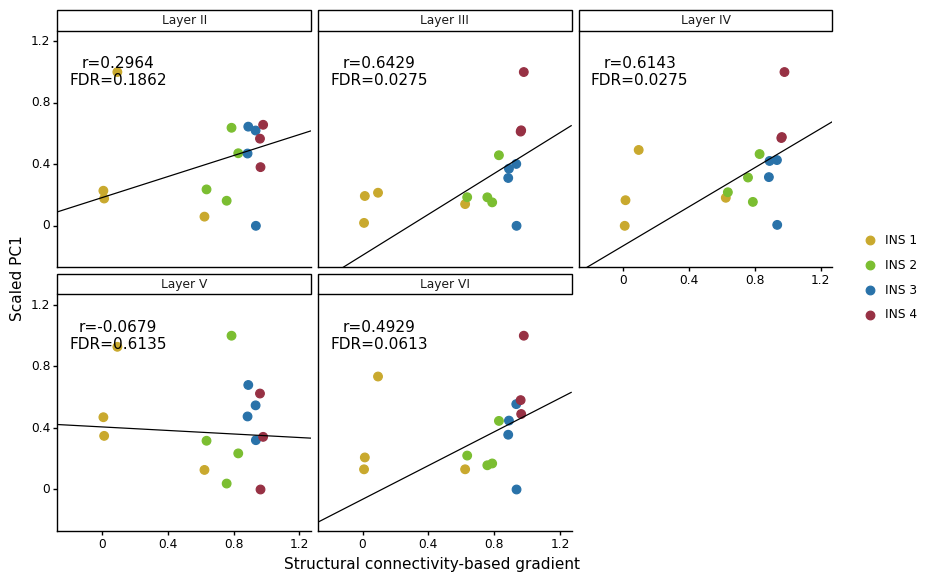

<ggplot: (8768890707706)>

In [84]:
layer_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="Group"), layer_dat_point)
  + p9.geom_point(size=3)
  + p9.geom_abline(p9.aes(slope="slope", intercept="intercept"), layer_dat_anno)
  + p9.geom_text(p9.aes(x=0.1, y=1, label="Labels"), layer_dat_anno, color="black")
  + p9.scale_color_manual(values=["#C9A92E", "#7BBE31", "#2972A9", "#973144"])
  + p9.theme_classic()
  + p9.xlab("Structural connectivity-based gradient") + p9.ylab("Scaled PC1")
  + p9.xlim(-0.2, 1.2) + p9.ylim(-0.2, 1.2)
  + p9.facet_wrap("~Layer", nrow=2, ncol=3)
  + p9.theme(axis_text=p9.element_text(color="black"),
             plot_title=p9.element_text(color="black", size=20),
             legend_title=p9.element_blank(),
             figure_size=(10, 6.5)
             )
  
)

#p9.ggsave(layer_plot, "../res/use_v1/layer_marker_corr.pdf", units="in", verbose=False)
layer_plot

## combine

In [9]:
diff_pro_dat["Layer"] = "Differential expressed proteins"
combine_point = pd.concat([diff_pro_dat, layer_dat_point], axis=0)

In [10]:
combine_point = pd.concat([diff_pro_dat, layer_dat_point], axis=0)

In [21]:
diff_pro_anno = [TheilSen_obj.coef_[0], TheilSen_obj.intercept_, "Differential expressed proteins", diff_pro_pval, diff_pro_rho, diff_pro_pval, f"r={diff_pro_rho:.4f}\np={diff_pro_pval:.4f}"]
combine_annot = pd.concat([pd.DataFrame(diff_pro_anno, index=layer_dat_anno.columns).T, layer_dat_anno], axis=0)

In [22]:
combine_annot.iloc[[0, 2, 3], :]

,slope,intercept,Layer,rho,pval,FDR,Labels
0,0.628761,-0.239777,Differential expressed proteins,0.0048,0.692857,0.0048,r=0.6929\np=0.0048
1,0.665249,-0.191656,Layer III,0.6429,0.010999,0.027497,r=0.6429\np=0.0275
2,0.635599,-0.130102,Layer IV,0.6143,0.010899,0.027497,r=0.6143\np=0.0275


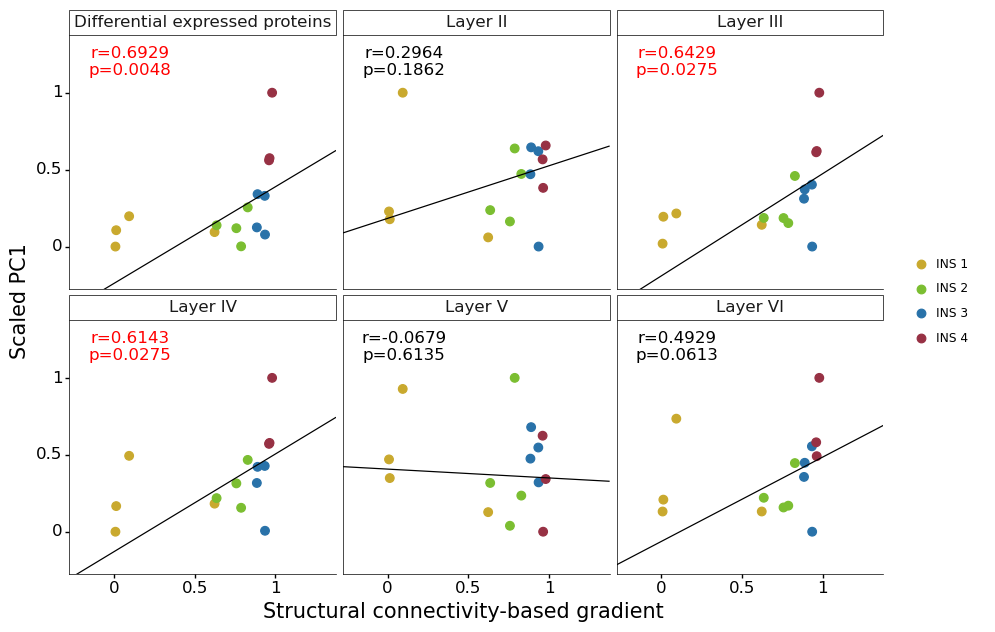

<ggplot: (8727795463783)>

In [42]:
layer_plot = ( p9.ggplot(p9.aes(x="x", y="y", color="Group"), combine_point)
  + p9.geom_point(size=3)
  + p9.geom_abline(p9.aes(slope="slope", intercept="intercept"), combine_annot)
  + p9.geom_text(p9.aes(x=0.1, y=1.2, label="Labels"), combine_annot.iloc[[1, 4, 5], :], color="black", size=12)
  + p9.geom_text(p9.aes(x=0.1, y=1.2, label="Labels"), combine_annot.iloc[[0, 2, 3], :], color="red", size=12)
  + p9.scale_color_manual(values=["#C9A92E", "#7BBE31", "#2972A9", "#973144"])
  + p9.theme_classic()
  + p9.xlab("Structural connectivity-based gradient") + p9.ylab("Scaled PC1")
  + p9.xlim(-0.2, 1.3) + p9.ylim(-0.2, 1.3)
  + p9.facet_wrap("~Layer", nrow=2, ncol=3)
  + p9.theme(axis_text=p9.element_text(color="black", size=12),
             axis_title=p9.element_text(color="black", size=15),
             #plot_title=p9.element_text(color="black", size=20),
             axis_line=p9.element_line(size=0.5),
             legend_title=p9.element_blank(),
             strip_background=p9.element_rect(size=0.5),
             strip_text=p9.element_text(size=12),
             figure_size=(10.5, 7)
             )
  
)

p9.ggsave(layer_plot, "../res/use_v1/combine_corr.tiff", units="in", dpi=300, verbose=False)
layer_plot